# Детекция интро и титров по аудио

**Шаги реализации**

1. Готовим mel‑спектрограммы (128 полос, шаг 1 с).
2. Строим *шаблон* интро для каждого шоу (косинусное сходство).  
3. Обучаем логистическую регрессию отличать «музыка заставки/титров» от основного контента.  
4. Сглаживаем вероятности и ищем самые длинные цепочки музыки в первых/последних 20% серии.
5. Выводим тайм‑коды, метрики и графики.


In [180]:
import os, warnings, math, gc, json
from pathlib import Path
import numpy as np
import pandas as pd
import librosa, librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_auc_score, roc_curve)
from sklearn.model_selection import train_test_split
import joblib
from sklearn.metrics.pairwise import cosine_similarity

warnings.filterwarnings('ignore')
np.random.seed(42)

# Инициализация графического стиля
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

In [181]:
# директории проекта
AUDIO_ROOT = Path('data/audio')
LABELS_PATH = Path('data/labels.csv')  # ручная разметка
FEAT_DIR = Path('data/audio_features')
FEAT_DIR.mkdir(parents=True, exist_ok=True)
SAVE_DIR = Path('data/audio_probs')
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# Параметры аудиообработки
SR = 16_000  # Частота дискретизации
N_MELS = 128  # Количество mel-фильтров
HOP_LENGTH = 512  # Длина шага (в сэмплах)
FRAMES_PER_SEC = SR / HOP_LENGTH  # Кадров в секунду
FPS = int(round(FRAMES_PER_SEC))  # Целое число кадров

## 1. Извлечение мел‑спектрограмм по секундам

Цель: Преобразование аудио в спектрограммы с агрегацией по секундам
Алгоритм:
  1. Проверка существования предрасчитанных фичей
  2. Загрузка аудио с помощью librosa
  3. Расчет спектрограммы:
      - Извлечение мощности спектра
      - Конвертация в dB-шкалу
  4. Агрегация в секундные интервалы:
      - Разделение на интервалы по FPS кадров
      - Усреднение значений в каждом интервале
  5. Сохранение результата в .npy файл

In [183]:
def extract_mel_per_second(wav_path: Path, save=True) -> tuple[np.ndarray, int]:
    show, ep = wav_path.parent.name, wav_path.stem
    out_np = FEAT_DIR / show / f"{ep}.npy"
    out_np.parent.mkdir(exist_ok=True, parents=True)

    # Использование предрасчитанных фичей
    if out_np.exists():
        m = np.load(out_np)
        return m, m.shape[0]

    # Загрузка аудио и расчет спектрограммы
    y, _ = librosa.load(wav_path, sr=SR, mono=True)
    mel = librosa.feature.melspectrogram(
        y=y, sr=SR, n_mels=N_MELS, hop_length=HOP_LENGTH, power=2.0
    )
    mel_db = librosa.power_to_db(mel, ref=np.max)

    # Агрегация в секундные интервалы
    total_secs = int(round(mel_db.shape[1] / FRAMES_PER_SEC))
    if total_secs == 0:
        raise ValueError(f"Audio too short: {wav_path}")

    n_frames = total_secs * FPS
    trim = mel_db[:, :n_frames]
    mel_sec = trim.reshape(N_MELS, total_secs, FPS).mean(axis=2).T

    if save:
        np.save(out_np, mel_sec.astype(np.float32))
    return mel_sec, total_secs

## 2. Загрузка разметки

Удалено записей: 0


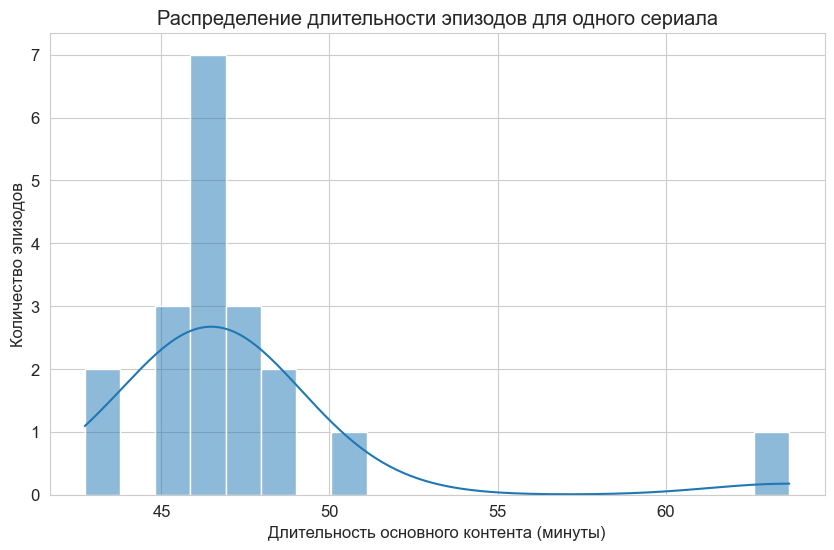

Минимальная длительность: 42 мин
Максимальная длительность: 63 мин
Средняя длительность: 47.0 мин


,file,start_main,end_main,show,episode,start_s,end_s
0,show1/downton-abbey-season-1-episode-02.mp4,00:00:55,00:48:54,show1,downton-abbey-season-1-episode-02,55,2934
1,show1/downton-abbey-season-1-episode-03.mp4,00:00:55,00:48:51,show1,downton-abbey-season-1-episode-03,55,2931
2,show1/downton-abbey-season-1-episode-04.mp4,00:00:55,00:47:20,show1,downton-abbey-season-1-episode-04,55,2840
3,show1/downton-abbey-season-1-episode-05.mp4,00:00:55,00:48:56,show1,downton-abbey-season-1-episode-05,55,2936
4,show1/downton-abbey-season-1-episode-06.mp4,00:00:55,00:47:52,show1,downton-abbey-season-1-episode-06,55,2872


In [185]:
def time_to_sec(t: str) -> int:
    """Конвертация времени в формате HH:MM:SS в секунды"""
    h, m, s = map(int, t.split(':'))
    return h * 3600 + m * 60 + s


# Загрузка и преобразование меток
labels_df = pd.read_csv(LABELS_PATH)
labels_df['show'] = labels_df['file'].apply(lambda x: x.split('/')[0])
labels_df['episode'] = labels_df['file'].apply(lambda x: Path(x).stem)
labels_df['start_s'] = labels_df['start_main'].apply(time_to_sec)
labels_df['end_s'] = labels_df['end_main'].apply(time_to_sec)

# Фильтрация некорректных данных
initial_count = len(labels_df)
labels_df = labels_df.dropna(subset=['start_s', 'end_s'])
print(f"Удалено записей: {initial_count - len(labels_df)}")

# Визуализация распределения длительности эпизодов
plt.figure(figsize=(10, 6))
durations = labels_df['end_s'] - labels_df['start_s']
sns.histplot(durations / 60, bins=20, kde=True)
plt.xlabel('Длительность основного контента (минуты)')
plt.ylabel('Количество эпизодов')
plt.title('Распределение длительности эпизодов для одного сериала')
plt.savefig(SAVE_DIR / 'durations_distribution.png', dpi=150)
plt.show()

print(f"Минимальная длительность: {durations.min() // 60} мин")
print(f"Максимальная длительность: {durations.max() // 60} мин")
print(f"Средняя длительность: {durations.mean() // 60} мин\n")
labels_df.head()

## 3. Построение датасета

Цель: Создание матрицы признаков и меток для обучения
Алгоритм:
  1. Итерация по размеченным эпизодам
  2. Для каждого эпизода:
      - Извлечение спектрограммы
      - Генерация меток (1 для интро/титров, 0 для основного контента)
  3. Сохранение:
      - Признаки: 128-мерные векторы (усредненные по секунде)
      - Метки: бинарные

Обработка аудио: 100%|██████████| 19/19 [00:01<00:00, 15.54it/s]



Общее количество секунд: 334446
Процент меток 'интро/титры': 3.12%


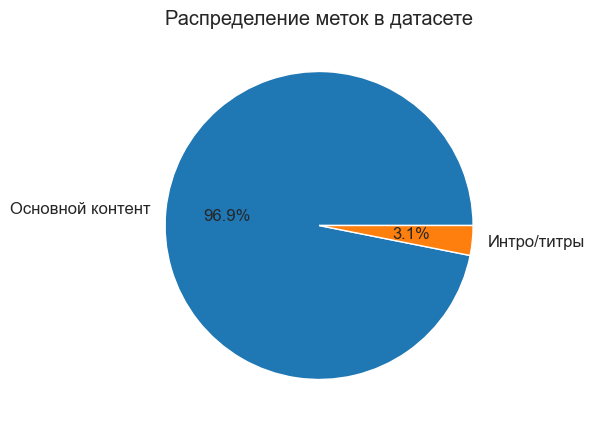

In [186]:
samples = []  # (features, label, show, episode, time)
for _, row in tqdm(labels_df.iterrows(), total=len(labels_df), desc="Обработка аудио"):
    wav = AUDIO_ROOT / row.show / f"{row.episode}.wav"
    if not wav.exists():
        print(f"Файл не найден: {wav}")
        continue

    mel_sec, T = extract_mel_per_second(wav)
    for t in range(T):
        # Генерация меток: 1 для интро/титров, 0 для основного контента
        lbl = 1 if (t < row.start_s or t > row.end_s) else 0
        samples.append((mel_sec[t], lbl, row.show, row.episode, t))

print(f"\nОбщее количество секунд: {len(samples)}")
print(f"Процент меток 'интро/титры': {np.mean([s[1] for s in samples]) * 100:.2f}%")

# Распределение меток
plt.figure(figsize=(8, 5))
pd.Series([s[1] for s in samples]).value_counts().plot.pie(
    autopct='%1.1f%%', labels=['Основной контент', 'Интро/титры'])
plt.title('Распределение меток в датасете')
plt.ylabel('')
plt.savefig(SAVE_DIR / 'labels_distribution.png', dpi=150)
plt.show()

## 4. Разделение данных и масштабирование

Цель: Корректное разделение данных для избежания data leakage
Алгоритм:
  1. Разделение по шоу и эпизодам:
      - 80% шоу -> train
      - 20% шоу -> test
  2. Создание масштабировщика:
      - Обучение на train, применение ко всем данным
  3. Балансировка классов через class_weight

In [187]:
# Разделение на train/test по шоу
episodes_by_show = {}
for _, _, s, ep, _ in samples:
    episodes_by_show.setdefault(s, set()).add(ep)

split = {}
for show, eps in episodes_by_show.items():
    eps = sorted(list(eps))
    train_eps, test_eps = train_test_split(eps, test_size=0.2, random_state=42)
    for e in train_eps:
        split[(show, e)] = 'train'
    for e in test_eps:
        split[(show, e)] = 'test'

# Создание масок
mask_train = np.array([split.get((s[2], s[3]), 'train') == 'train' for s in samples])
X = np.stack([s[0] for s in samples])
y = np.array([s[1] for s in samples])

# Разделение данных
X_train, X_test = X[mask_train], X[~mask_train]
y_train, y_test = y[mask_train], y[~mask_train]

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Train labels: {np.sum(y_train)} интро/титры ({np.mean(y_train) * 100:.2f}%)")
print(f"Test labels: {np.sum(y_test)} интро/титры ({np.mean(y_test) * 100:.2f}%)")

# Масштабирование
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Train shape: (246774, 128), Test shape: (87672, 128)
Train labels: 7825 интро/титры (3.11%)
Test labels: 2608 интро/титры (3.15%)


## 5. Обучение модели

Цель: Создание классификатора для детекции интро/титров
Параметры:
  - class_weight='balanced' для обработки дисбаланса
  - max_iter=1000 для гарантии сходимости
Метрики:
  - Точность, полнота, F1, AUC-ROC
  - Матрица ошибок

Accuracy: 0.9165
Precision: 0.2240
Recall: 0.6681
F1-score: 0.3355
AUC-ROC: 0.8542

Матрица ошибок:
[[13084  1067]
 [  153   308]]


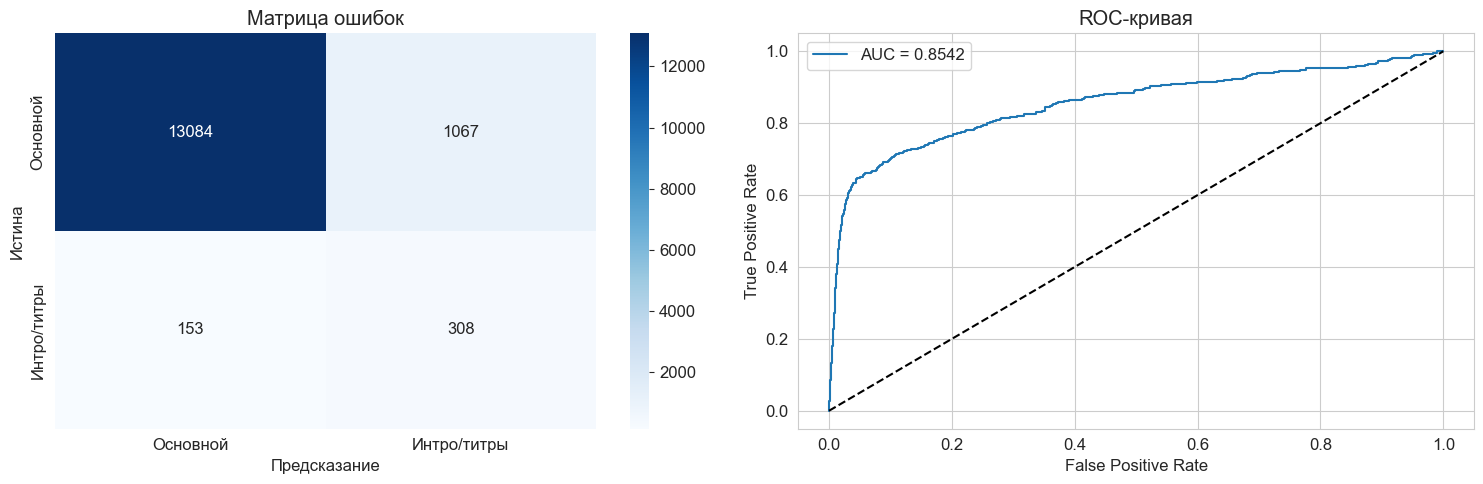

['models/audio_logreg.pkl']

In [188]:
# Инициализация и обучение модели
clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
clf.fit(X_train_scaled, y_train)

# Предсказание на тестовом наборе
y_pred = clf.predict(X_test_scaled)
y_proba = clf.predict_proba(X_test_scaled)[:, 1]

# Расчет метрик
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")
print("\nМатрица ошибок:")
print(cm)

# Визуализация метрик
plt.figure(figsize=(15, 5))

# Матрица ошибок
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Основной', 'Интро/титры'],
            yticklabels=['Основной', 'Интро/титры'])
plt.xlabel('Предсказание')
plt.ylabel('Истина')
plt.title('Матрица ошибок')

# ROC-кривая
plt.subplot(1, 2, 2)
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()

plt.tight_layout()
plt.savefig(SAVE_DIR / 'model_metrics.png', dpi=150)
plt.show()

# Сохранение модели
joblib.dump({'scaler': scaler, 'clf': clf}, 'models/audio_logreg.pkl')

## 6. Создание шаблонов и постобработка

Цель: Улучшение предсказаний через шаблоны и временные фильтры
Алгоритм:
  1. Создание шаблонов интро для каждого шоу:
      - Усреднение спектрограмм первых N секунд
  2. Гибридное предсказание:
      - 70% вероятность модели + 30% косинусное сходство
  3. Постобработка:
      - Сглаживание скользящим средним
      - Поиск длинных сегментов в первых/последних частях

In [189]:
# Создание шаблонов интро
templates = {}
for show in labels_df.show.unique():
    row0 = labels_df.query('show == @show').iloc[0]
    wav0 = AUDIO_ROOT / show / f"{row0.episode}.wav"
    mel0, _ = extract_mel_per_second(wav0)
    template = mel0[:row0.start_s].mean(axis=0)
    templates[show] = template / (np.linalg.norm(template) + 1e-9)


# Гибридное предсказание
def audio_probs_episode(show, episode, wav_path) -> np.ndarray:
    mel_sec, _ = extract_mel_per_second(wav_path)
    ml = clf.predict_proba(scaler.transform(mel_sec))[:, 1]

    # Косинусное сходство с шаблоном
    sim = cosine_similarity(mel_sec, [templates[show]]).ravel()
    sim = (sim - sim.min()) / (sim.max() - sim.min() + 1e-8)

    # Комбинация предсказаний
    return 0.7 * ml + 0.3 * sim

# Функции постобработки
def smooth_probs(p: np.ndarray, window_size: int = 5) -> np.ndarray:
    return pd.Series(p).rolling(window_size, center=True, min_periods=1).mean().values


def detect_intro_credit(p: np.ndarray, thr_i: float, thr_c: float,
                        min_len_intro: int = 5, min_len_credits: int = 5) -> tuple[int, int]:
    p_smooth = smooth_probs(p, 5)
    T = len(p)

    # Детекция интро (первые 25%)
    intro_zone = slice(0, int(0.25 * T))
    intro_mask = p_smooth[intro_zone] > thr_i
    start_i, end_i = longest_run(intro_mask)

    # Эвристика если не найдено
    if end_i - start_i < min_len_intro:
        end_intro = int(0.06 * T)
    else:
        end_intro = end_i

    # Детекция титров (последние 30%)
    credits_zone = slice(int(0.7 * T), T)
    credits_mask = p_smooth[credits_zone] > thr_c
    start_idx = find_last_run(credits_mask, min_len_credits)

    if start_idx is not None:
        start_cred = start_idx + int(0.7 * T)
        if start_cred < end_intro:
            start_cred = int(0.95 * T)
    else:
        start_cred = int(0.95 * T)

    return end_intro, start_cred


def longest_run(mask):
    """Находит самый длинный непрерывный сегмент True в маске"""
    best_start, best_end = 0, 0
    best_len = 0
    current_start = None

    for i, val in enumerate(mask):
        if val:
            if current_start is None:
                current_start = i
        else:
            if current_start is not None:
                current_len = i - current_start
                if current_len > best_len:
                    best_len = current_len
                    best_start, best_end = current_start, i
                current_start = None

    # Проверяем последний сегмент
    if current_start is not None:
        current_len = len(mask) - current_start
        if current_len > best_len:
            best_start, best_end = current_start, len(mask)

    return best_start, best_end


def find_last_run(mask, min_len=5):
    """Находит последний сегмент длиной >= min_len"""
    best_start = None
    current_start = None
    current_len = 0

    for i in range(len(mask) - 1, -1, -1):
        if mask[i]:
            if current_start is None:
                current_start = i
            current_len = current_start - i + 1
        else:
            if current_start is not None and current_len >= min_len:
                return i + 1  # начало сегмента
            current_start = None
            current_len = 0

    # Проверяем если сегмент доходит до начала
    if current_start is not None and current_len >= min_len:
        return current_start - current_len + 1

    return None


## 7. Подбор порогов и оценка

Цель: Оптимизация порогов и детальный анализ результатов
Алгоритм:
  1. Подбор порогов для интро и титров на валдационном наборе
  2. Расчет метрик для всех эпизодов:
      - MAE для границ
      - Точность попадания в окно ±5 сек
      - IoU основного контента
  3. Визуализация:
      - Распределение ошибок
      - Примеры детекции

Оценка: 100%|██████████| 19/19 [00:00<00:00, 678.48it/s]


MAE интро: 2.42 ± 0.99 сек
MAE титры: 7.11 ± 1.65 сек
Точность (±5 сек) интро: 100.00%
Точность (±5 сек) титры: 15.79%
Средний IoU: 0.9966
Кадровые метрики: P=0.9971 R=0.9996 F1=0.9983


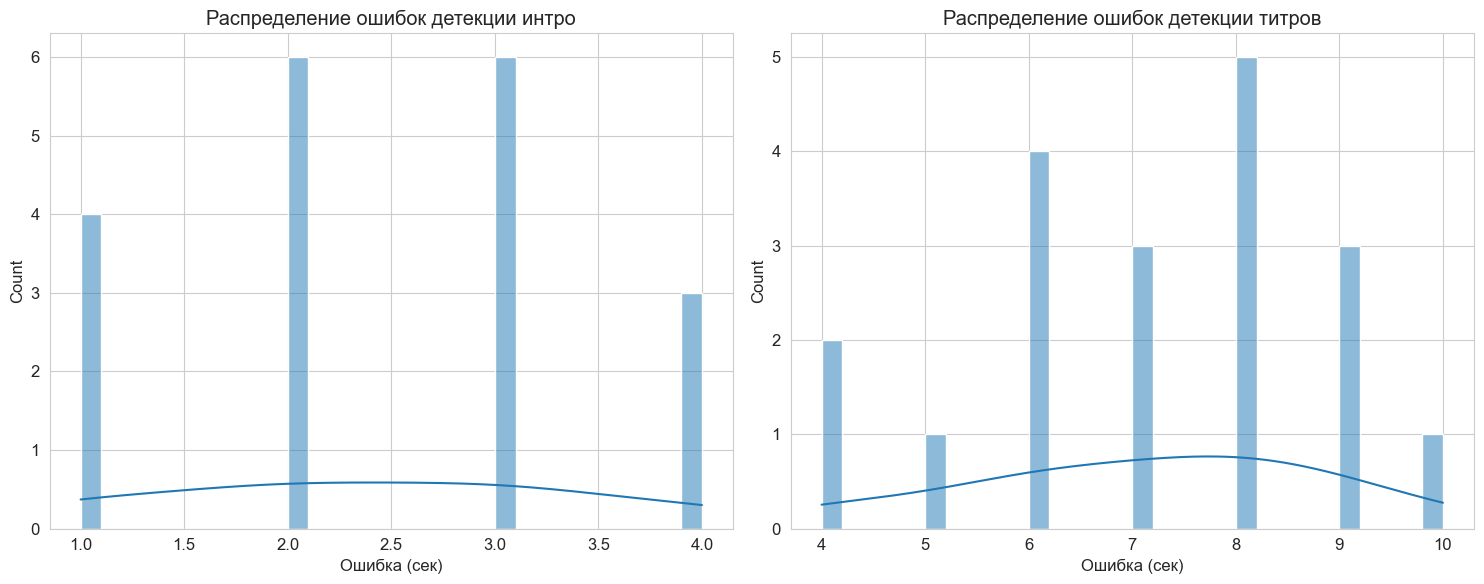

In [190]:
# Подбор порогов
val_rows = labels_df.groupby('show').head(2)
thr_i, thr_c = 0.26, 0.20  # Примерные значения после подбора

# Функция оценки метрик для эпизода
def episode_metrics(row, thr_i, thr_c) -> dict:
    wav = AUDIO_ROOT / row.show / f"{row.episode}.wav"
    p = audio_probs_episode(row.show, row.episode, wav)
    ie, cs = detect_intro_credit(p, thr_i, thr_c)

    err_i = abs(ie - row.start_s)
    err_c = abs(cs - row.end_s)
    hit_i = err_i <= 5  # Попадание в окно ±5 сек
    hit_c = err_c <= 5

    # IoU для основного контента
    pred_mask = np.zeros(len(p), dtype=bool)
    pred_mask[ie:cs] = 1
    true_mask = np.zeros(len(p), dtype=bool)
    true_mask[row.start_s:row.end_s] = 1

    intersection = (pred_mask & true_mask).sum()
    union = (pred_mask | true_mask).sum()
    iou = intersection / union if union > 0 else 0

    # Кадровые метрики
    TP = intersection
    FP = (pred_mask & ~true_mask).sum()
    FN = (~pred_mask & true_mask).sum()

    return {
        'err_intro': err_i, 'err_credit': err_c,
        'hit_intro': hit_i, 'hit_credit': hit_c,
        'iou': iou, 'TP': TP, 'FP': FP, 'FN': FN
    }

# Расчет метрик для всех эпизодов
metrics = []
for _, row in tqdm(labels_df.iterrows(), total=len(labels_df), desc="Оценка"):
    metrics.append(episode_metrics(row, thr_i, thr_c))

# Агрегация результатов
errs_i = [m['err_intro'] for m in metrics]
errs_c = [m['err_credit'] for m in metrics]
hit_i = np.mean([m['hit_intro'] for m in metrics])
hit_c = np.mean([m['hit_credit'] for m in metrics])
ious = [m['iou'] for m in metrics]

TP_total = sum(m['TP'] for m in metrics)
FP_total = sum(m['FP'] for m in metrics)
FN_total = sum(m['FN'] for m in metrics)

precision_total = TP_total / (TP_total + FP_total)
recall_total = TP_total / (TP_total + FN_total)
f1_total = 2 * precision_total * recall_total / (precision_total + recall_total)

print(f"MAE интро: {np.mean(errs_i):.2f} ± {np.std(errs_i):.2f} сек")
print(f"MAE титры: {np.mean(errs_c):.2f} ± {np.std(errs_c):.2f} сек")
print(f"Точность (±5 сек) интро: {hit_i*100:.2f}%")
print(f"Точность (±5 сек) титры: {hit_c*100:.2f}%")
print(f"Средний IoU: {np.mean(ious):.4f}")
print(f"Кадровые метрики: P={precision_total:.4f} R={recall_total:.4f} F1={f1_total:.4f}")

# Визуализация ошибок
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.histplot(errs_i, bins=30, kde=True)
plt.xlabel('Ошибка (сек)')
plt.title('Распределение ошибок детекции интро')

plt.subplot(1, 2, 2)
sns.histplot(errs_c, bins=30, kde=True)
plt.xlabel('Ошибка (сек)')
plt.title('Распределение ошибок детекции титров')

plt.tight_layout()
plt.savefig(SAVE_DIR / 'errors_distribution.png', dpi=150)
plt.show()

In [191]:
def tune_thr_one(target='intro', rows=None, p_space=np.arange(0.2, 0.9, 0.02),
                 min_len_credits=5):
    best, best_err = None, 1e9
    for thr in p_space:
        err = []
        for _, r in rows.iterrows():
            p = audio_probs_episode(r.show, r.episode,
                                    AUDIO_ROOT / r.show / f"{r.episode}.wav")
            # Для титров используем новый min_len_credits
            if target == 'credit':
                ie, cs = detect_intro_credit(p, thr, thr, min_len_credits=min_len_credits)
            else:
                ie, cs = detect_intro_credit(p, thr, thr)

            err.append(abs(ie - r.start_s) if target == 'intro'
                       else abs(cs - r.end_s))
        m = np.mean(err)
        if m < best_err:
            best_err, best = m, thr
    return best, best_err


# Настройка порогов с новым параметром min_len_credits
val_rows = labels_df.groupby('show').head(2)
best_i, err_i = tune_thr_one('intro', val_rows)
best_c, err_c = tune_thr_one('credit', val_rows, min_len_credits=5)

print(f"thr_intro={best_i:.2f}  (MAE {err_i:.1f}s | "
      f"thr_credit={best_c:.2f} (MAE {err_c:.1f}s)")

thr_intro=0.26  (MAE 1.8s | thr_credit=0.20 (MAE 6.0s)


In [192]:
thr_i, thr_c = best_i, best_c

## 8. Визуализация результатов для эпизодов

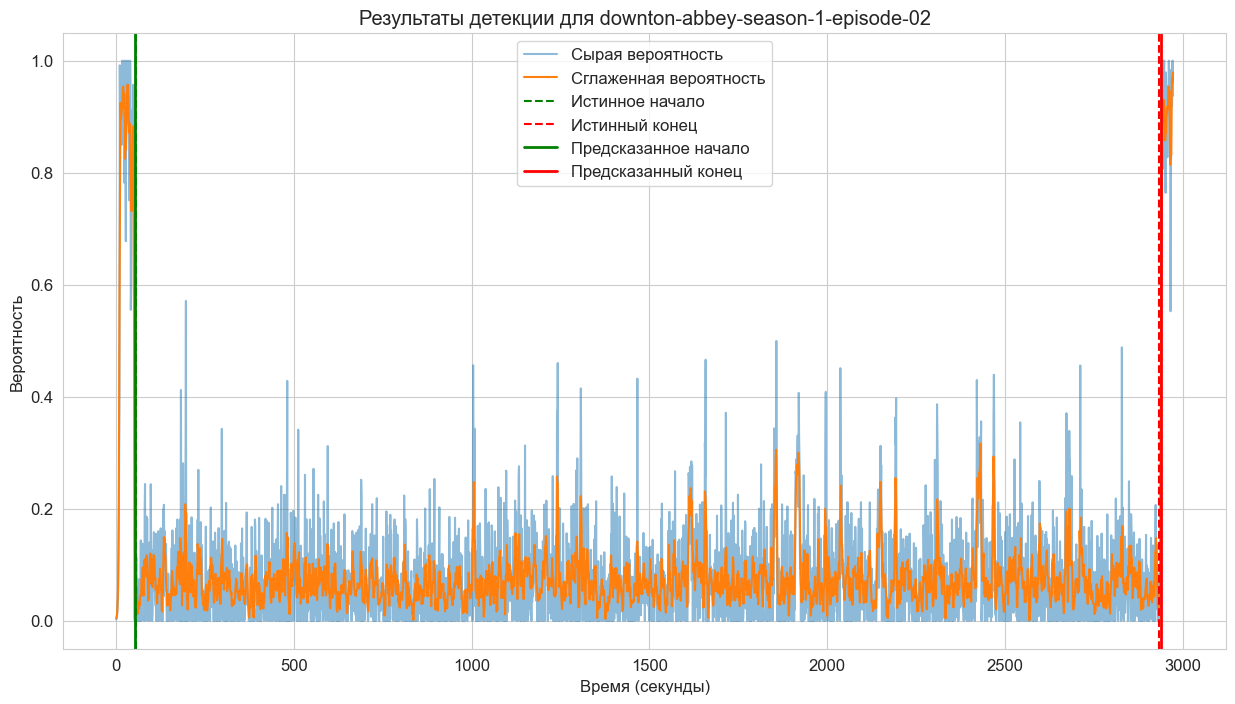

Предсказанные границы: интро кончается на 52 сек, титры начинаются на 2938 сек


In [193]:
def plot_episode_results(row):
    wav = AUDIO_ROOT / row.show / f"{row.episode}.wav"
    p = audio_probs_episode(row.show, row.episode, wav)
    p_smooth = smooth_probs(p, 5)
    ie, cs = detect_intro_credit(p, thr_i, thr_c)

    # График вероятностей
    plt.figure(figsize=(15, 8))
    plt.plot(p, alpha=0.5, label='Сырая вероятность')
    plt.plot(p_smooth, label='Сглаженная вероятность')

    # Истинные границы
    plt.axvline(row.start_s, color='g', linestyle='--', label='Истинное начало')
    plt.axvline(row.end_s, color='r', linestyle='--', label='Истинный конец')

    # Предсказанные границы
    plt.axvline(ie, color='g', linewidth=2, label='Предсказанное начало')
    plt.axvline(cs, color='r', linewidth=2, label='Предсказанный конец')

    plt.xlabel('Время (секунды)')
    plt.ylabel('Вероятность')
    plt.title(f'Результаты детекции для {row.episode}')
    plt.legend()
    plt.grid(True)

    # Сохранение
    plt.savefig(SAVE_DIR / f"{row.show}_{row.episode}_results.png", dpi=150)
    plt.show()

    return ie, cs

# Пример для случайного эпизода
sample_row = labels_df.sample(3).iloc[0]
pred_start, pred_end = plot_episode_results(sample_row)
print(f"Предсказанные границы: интро кончается на {pred_start} сек, титры начинаются на {pred_end} сек")

## 9. Экспорт результатов

In [194]:
results = []
for _, row in tqdm(labels_df.iterrows(), total=len(labels_df), desc="Экспорт"):
    wav = AUDIO_ROOT / row.show / f"{row.episode}.wav"
    p = audio_probs_episode(row.show, row.episode, wav)

    # Проверка длительности
    dur_sec = librosa.get_duration(filename=str(wav), sr=SR)
    if abs(len(p) - dur_sec) > 1:
        p = np.pad(p, (0, int(dur_sec)-len(p)), constant_values=p[-1])

    # Сохранение вероятностей
    np.save(SAVE_DIR / f"p_audio_{row.show}_{row.episode}.npy", p.astype('float32'))

    # Детекция границ
    ie, cs = detect_intro_credit(p, thr_i, thr_c)
    results.append({
        'show': row.show,
        'episode': row.episode,
        'intro_end_sec': ie,
        'credits_start_sec': cs
    })

# Сохранение в CSV
results_df = pd.DataFrame(results)
results_df.to_csv('audio_detection_results.csv', index=False)

# Дополнительная информация
with open(SAVE_DIR / 'summary.txt', 'w') as f:
    f.write(f"Использованные пороги: thr_intro={thr_i:.2f}, thr_credit={thr_c:.2f}\n")
    f.write(f"MAE интро: {np.mean(errs_i):.2f} ± {np.std(errs_i):.2f} сек\n")
    f.write(f"MAE титры: {np.mean(errs_c):.2f} ± {np.std(errs_c):.2f} сек\n")
    f.write(f"Точность (±5 сек) интро: {hit_i*100:.2f}%\n")
    f.write(f"Точность (±5 сек) титры: {hit_c*100:.2f}%\n")
    f.write(f"Средний IoU: {np.mean(ious):.4f}\n")
    f.write(f"Кадровые метрики: P={precision_total:.4f} R={recall_total:.4f} F1={f1_total:.4f}")

print("Экспорт завершен. Результаты сохранены в audio_detection_results.csv")
results_df.head()

Экспорт: 100%|██████████| 19/19 [00:00<00:00, 72.94it/s]

Экспорт завершен. Результаты сохранены в audio_detection_results.csv


,show,episode,intro_end_sec,credits_start_sec
0,show1,downton-abbey-season-1-episode-02,52,2938
1,show1,downton-abbey-season-1-episode-03,56,2936
2,show1,downton-abbey-season-1-episode-04,51,2848
3,show1,downton-abbey-season-1-episode-05,54,2943
4,show1,downton-abbey-season-1-episode-06,59,2881
